In [1]:
import MGTomo.model as mgmodel
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import mylog
import MGTomo.functions as fcts
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import RBox as R, PBox as P

from MGTomo import gridop

import time
import numpy as np
import torch
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize

In [2]:
max_levels = 4
maxIter = [1,2,5,5,5,5]

In [3]:
N = 511
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}
P_nonzero = []


for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [6]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [7]:
tau = [tau0]*(max_levels+1)

In [8]:
# def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
#     gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
#     if gcond:
#         if y_last is not None:
#             y_diff_norm = matrix_norm(y_last - y)
#             y_norm = matrix_norm(y)
#             return (y_diff_norm >= eta * y_norm)
#         return True
#     else:
#         return False

In [9]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last=None):
    grad_y_norm = matrix_norm(grad_y)
    if matrix_norm(R(grad_y)) >= kappa * grad_y_norm:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            if y_diff_norm >= eta * matrix_norm(y):
                return True
        return y_last is None
    return False


In [10]:
def coarse_condition_kl(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if y_last is not None:
        y_diff_norm = fcts.kl_distance_no_matrix(y_last, y)
        return gcond and (y_diff_norm >= eta * y.flatten().size()[0])
    else:
        return gcond

In [11]:
def coarse_condition_v3(grad_y, kappa, eps):
    Rgrady = matrix_norm( R(grad_y))
    gcond_rel = (Rgrady >= kappa * matrix_norm(grad_y))
    gcond = (Rgrady >= eps)
    
    return gcond_rel and gcond

In [12]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

In [13]:
def box_projection(x, l, u):
    mask_l = (x < l)
    proj_x = torch.where(mask_l, x, l)

    mask_u = (x > u)
    proj_x = torch.where(mask_u, proj_x, u)

    return proj_x

In [14]:
def coarse_condition_proj(y, x, lH, uH, lh, uh, kappa):
    proj_x = box_projection(x, lH, uH)
    proj_y = box_projection(y, lh, uh)

    gcond = matrix_norm(proj_x - x) >= kappa * matrix_norm(proj_y - y)

    return gcond

In [15]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001, verbose = True):
    x = R(y).detach().requires_grad_(True)
    
    fhy0 = fh(y)
    #fhy0.backward(retain_graph = True)
    fhy0.backward()
    grad_fhy0 = y.grad.clone()
    y.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y, x, P_inf, lh, uh, P_nonzero[l])

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l]):
            #x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.detach().requires_grad_(True)
    return y, last_pts


In [16]:
P_inf = 1
a = []
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts, verbose=False)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 0: 380532.86185770185 - Time: 11.824237 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 1: 212435.14101737557 - Time: 10.980073 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 2: 124804.66003588018 - Time: 11.119858 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 3: 79259.85675536904 - Time: 10.982010 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 4: 55062.62154620978 - Time: 11.062325 seconds
0  : coarse correction activated

In [18]:
w0 = torch.ones(N, N) * 0.5
w0.requires_grad_(True)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    w0, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau0, lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 3040.59974544408 - Time: 0.436542 seconds
Iteration 1: 3040.59974544408 - Time: 0.395287 seconds
Iteration 2: 3040.59974544408 - Time: 0.488539 seconds
Iteration 3: 3040.59974544408 - Time: 0.347785 seconds
Iteration 4: 3040.59974544408 - Time: 0.440051 seconds
Iteration 5: 3040.59974544408 - Time: 0.424789 seconds


KeyboardInterrupt: 

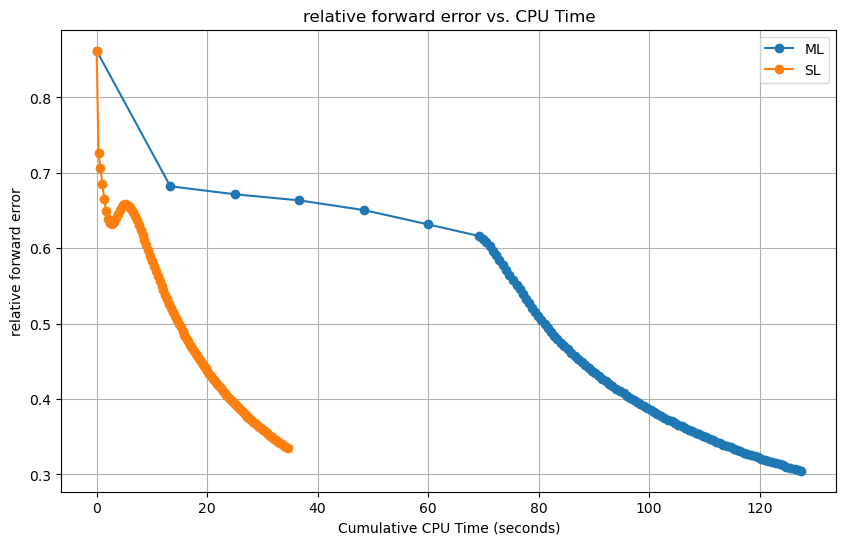

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
#plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.plot(cumaltive_times_ML, rel_f_err, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, rel_f_err_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('relative forward error')
plt.title('relative forward error vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

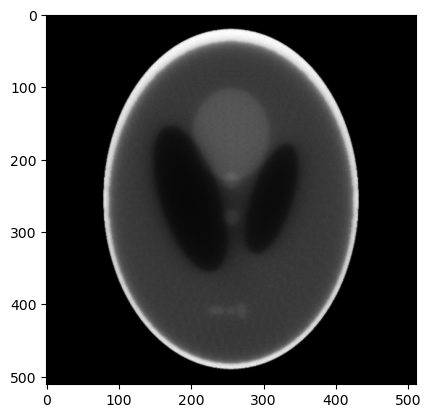

In [ ]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')